#### Packages

In [59]:
import scipy.io
import json
from numpy import *
from tqdm import trange
import math

import torch.utils.data as data
from PIL import Image
import numpy as np
from torchvision.datasets import EMNIST
from torchvision.datasets import DatasetFolder
from torchvision import transforms
import copy
%matplotlib inline
import matplotlib.pyplot as plt

#### Useful functions

In [60]:
def SQuantization(s,x): 
    
    # s : number of quantization levels
    # x : vector to compress
    
    if s == 0:
        return x
    norm_x = np.linalg.norm(x,2)
    if norm_x == 0:
        return x
    ratio = np.abs(x) / norm_x
    l = np.floor(ratio * s)
    p = ratio * s - l
    sampled = np.random.binomial(1,p)
    qtzt = np.sign(x) * norm_x * (l + sampled) / s
    return qtzt

def com_bits(s,d):
    if s <= np.sqrt(d/2 - np.sqrt(d)):
        return (3 + (3/2) * np.log(2*(s**2 + d)/(s*(s+np.sqrt(d))))) * s*(s+np.sqrt(d)) + 32
    elif s == np.sqrt(d):
        return 2.8*d + 32
    else:
        return ((1/2)*(np.log(1 + (s**2+np.minimum(d,s*np.sqrt(d)))/d) + 1) + 2) * d + 32

## 1. Binomial logistic regression on Synthetic($\alpha$,$\beta$) dataset

#### Global parameters

In [320]:
b = 20 # number of clients
K = 2 # number of classes
d = 10 # dimension

#### Useful functions

In [321]:
def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum( np.exp(x))
    return ex/sum_ex


def generate_synthetic(alpha, beta, iid, d, K, b):
    
    
    np.random.seed(1994)
    #samples_per_user = np.random.lognormal(4, 2, (b)).astype(int) + 50
    samples_per_user = np.random.randint(low=10,high=50,size=b).astype(int)
    num_samples = np.sum(samples_per_user)

    X_split = [[] for _ in range(b)]
    y_split = [[] for _ in range(b)]


    #### define some eprior ####
    np.random.seed(1994)
    mean_W = np.random.normal(0, alpha, b)
    mean_b = mean_W
    np.random.seed(1994)
    B = np.random.normal(0, beta, b)
    mean_x = np.zeros((b, d))

    diagonal = np.zeros(d)
    for j in range(d):
        diagonal[j] = np.power((j+1), -1.2)
    cov_x = np.diag(diagonal)

    for i in range(b):
        if iid == 1:
            mean_x[i] = np.ones(d) * B[i]  # all zeros
        else:
            np.random.seed(1994)
            mean_x[i] = np.random.normal(B[i], 1, d)

    if iid == 1:
        np.random.seed(1994)
        W_global = np.random.normal(0, 1, (d, K))
        np.random.seed(1994)
        b_global = np.random.normal(0, 1,  K)

    for i in range(b):
        np.random.seed(1994)
        W = np.random.normal(mean_W[i], 1, (d, K))
        np.random.seed(1994)
        b = np.random.normal(mean_b[i], 1,  K)

        if iid == 1:
            W = W_global
            b = b_global
        np.random.seed(1994)
        xx = np.random.multivariate_normal(mean_x[i], cov_x, samples_per_user[i])
        yy = np.zeros(samples_per_user[i])

        for j in range(samples_per_user[i]):
            tmp = np.dot(xx[j], W) + b
            yy[j] = np.argmax(softmax(tmp))

        X_split[i] = xx.tolist()
        y_split[i] = yy.tolist()

    return X_split, y_split



train_data = {'users': [], 'user_data':{}, 'num_samples':[]}
test_data = {'users': [], 'user_data':{}, 'num_samples':[]}


X, y = generate_synthetic(alpha=1, beta=1, iid=0, d=d, K=K, b=b)     # synthetic (1,1)


# Create data structure
train_data = {'users': [], 'user_data':{}, 'num_samples':[]}
test_data = {'users': [], 'user_data':{}, 'num_samples':[]}
    
for i in trange(b, ncols=120):

    uname = 'f_{0:05d}'.format(i)        
    combined = list(zip(X[i], y[i]))
    random.shuffle(combined)
    X[i][:], y[i][:] = zip(*combined)
    num_samples = len(X[i])
    train_len = int(0.9 * num_samples)
    test_len = num_samples - train_len
        
    train_data['users'].append(uname) 
    train_data['user_data'][uname] = {'x': X[i][:train_len], 'y': y[i][:train_len]}
    train_data['num_samples'].append(train_len)
    test_data['users'].append(uname)
    test_data['user_data'][uname] = {'x': X[i][train_len:], 'y': y[i][train_len:]}
    test_data['num_samples'].append(test_len)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


#### Display data distribution

Text(0.5, 1.0, 'Synthetic$(\\alpha,\\beta)$ dataset with $\\alpha=1$, $\\beta=1$')

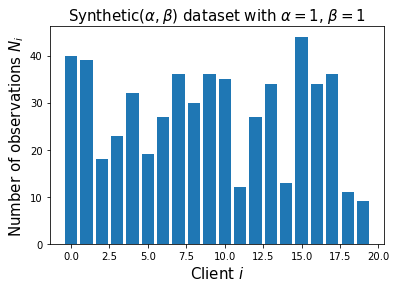

In [322]:
n = np.zeros(b)
for i in range(b):
    n[i] = np.size(train_data['user_data'][train_data['users'][i]]['x'],0)
n = n.astype(int)
plt.figure()
plt.bar(range(b),n)
plt.xlabel(r'Client $i$',size=15)
plt.ylabel(r'Number of observations $N_i$',size=15)
plt.title(r'Synthetic$(\alpha,\beta)$ dataset with $\alpha=1$, $\beta=1$',size=15)

#### Preprocessing

In [323]:
# Define the observations vector y
y = []
for i in range(b):
    a = np.reshape(train_data['user_data'][train_data['users'][i]]['y'],(n[i],))
    a[a == -1] = 0
    y.append(a)
    
# Define the observation matrix X
X = []
for i in range(b):
    a = np.reshape(train_data['user_data'][train_data['users'][i]]['x'],(n[i],d))
    X.append(a)
    
# Define total observations and features
y_tot = np.concatenate(y,axis=0)
X_tot = np.concatenate(X,axis=0)
SigmaX = X_tot.T.dot(X_tot) / np.sum(n)
U, S, V = np.linalg.svd(SigmaX, full_matrices=True,hermitian=True)
A = U.dot(np.diag(S**(-1/2))).dot(U.T)
B = U.dot(np.diag(S**(1/2))).dot(U.T)
Xprec_tot = X_tot.dot(A)

Xprec = []
for i in range(b):
    if i==0:
        a = Xprec_tot[0:n[i],:]
    else:
        a = Xprec_tot[n[i-1]:n[i-1]+n[i],:]
    Xprec.append(a)

#### Algorithms

In [324]:
def MALA(T_total,T_bi,T,gamma,init):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    
    # Initialisation
    theta[0,:] = init
    x = theta[0,:]
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (tau/2) * np.linalg.norm(x)**2
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
        grad = np.dot(X_tot.T, np.reshape(P - y_tot,(np.sum(n),))) + tau * x
        grad = np.reshape(grad,(d,))
        s = np.zeros(d)
        s = x - gamma * grad + np.sqrt(2*gamma) * np.random.normal(0,1,d)
    
        u = np.random.uniform()
        P = 1 / (1 + np.exp(-np.dot(X_tot,s)))
        U = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + tau/2 * np.linalg.norm(s)**2
        P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
        U_old = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + tau/2 * np.linalg.norm(x)**2
        P = 1 / (1 + np.exp(-np.dot(X_tot,s)))
        grad_prop = np.dot(X_tot.T, np.reshape(P - y_tot,(np.sum(n),))) + tau * s
        grad_prop = np.reshape(grad,(d,))
        ratio = np.exp(-U + U_old \
                       - (1/(4*gamma))*np.linalg.norm(x - s + gamma * grad_prop,2)**2 \
                       + (1/(4*gamma))*np.linalg.norm(s - x + gamma * grad,2)**2)
        #print(min(1,ratio))
        if u <= ratio:
            x = s
          
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (tau/2) * np.linalg.norm(x)**2
            
            # Accuracy
            a = np.exp(X_tot.dot(x)) / (1 + np.exp(X_tot.dot(x)))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
        
        if t % 100000 == 0:
            print(t)
            
    return theta, loss, acc

def ULA(T_total,T_bi,T,gamma,init):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    
    # Initialisation
    theta[0,:] = init
    x = theta[0,:]
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (tau/2) * np.linalg.norm(x)**2
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
        grad = np.dot(X_tot.T, np.reshape(P - y_tot,(np.sum(n),))) + tau * x
        grad = np.reshape(grad,(d,))
        s = np.zeros(d)
        x = x - gamma * grad + np.sqrt(2*gamma) * np.random.normal(0,1,d)
          
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (tau/2) * np.linalg.norm(x)**2
            
            # Accuracy
            a = np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])) / (1 + np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
        
        if t % 100000 == 0:
            print(t)
            
    return theta, loss, acc

def QLSDpp(T_total,T_bi,T,gamma,p,init,s,K,beta,memory):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    h = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (tau/2) * np.linalg.norm(theta[0,:])**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
             # Compute full gradient at control variate
            P = 1 / (1 + np.exp(-np.dot(X[i],z)))
            fullgrad_z = -np.dot(X[i].T, np.reshape(y[i] - P,(n[i],))) + tau * n[i]/np.sum(n) * z
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = (1 / (1 + np.exp(-np.dot(X[i][idx,:],x))) - y[i][idx]) * X[i][idx,:] \
                         + tau * (1/np.sum(n)) * x
            grad_z = (1 / (1 + np.exp(-np.dot(X[i][idx,:],z))) - y[i][idx]) * X[i][idx,:] \
                         + tau * (1/np.sum(n)) * z
            grad = n[i] * (grad_theta - grad_z) + fullgrad_z

            # Quantize the stochastic gradient minus memory term
            qqgrad = SQuantization(s, grad - h[i,:])
            qgrad[i,:] = qqgrad + h[i,:]
            if memory == True:
                h[i,:] = h[i,:] + beta * qqgrad   
        
        
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) \
                                           + (tau/2) * np.linalg.norm(x)**2
            
    return theta, loss

def LSDpp(T_total,T_bi,T,gamma,p,init,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    grad = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (tau/2) * np.linalg.norm(theta[0,:])**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
             # Compute full gradient at control variate
            P = 1 / (1 + np.exp(-np.dot(X[i],z)))
            fullgrad_z = -np.dot(X[i].T, np.reshape(y[i] - P,(n[i],))) + tau * n[i]/np.sum(n) * z
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = (1 / (1 + np.exp(-np.dot(X[i][idx,:],x))) - y[i][idx]) * X[i][idx,:] \
                         + tau * (1/np.sum(n)) * x
            grad_z = (1 / (1 + np.exp(-np.dot(X[i][idx,:],z))) - y[i][idx]) * X[i][idx,:] \
                         + tau * (1/np.sum(n)) * z
            grad[i,:] = n[i] * (grad_theta - grad_z) + fullgrad_z 
        
        
        # Update theta on server
        x = x - gamma * np.sum(grad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) \
                                           + (tau/2) * np.linalg.norm(x)**2
            
    return theta, loss

In [325]:
w, v = np.linalg.eig(X_tot.T.dot(X_tot))
w = np.max(w.real)
tau = 1000
M = w/4 + tau
S = [2**1,2**2,2**4]
K = 100
gamma = 1/(M)
omega = [np.minimum(d/s**2,np.sqrt(d)/s) for s in S]
T = 10000

thetaMALA, lossMALA, acc = MALA(T_total=T,T_bi=0,T=T,gamma=1/(10*M),init=np.zeros(d))
thetaULA, lossULA, acc = ULA(T_total=T,T_bi=0,T=T,gamma=gamma,init=np.zeros(d))

# Repetitions
rep = 1

# Init.
theta1 = np.zeros((rep,T,d))
theta2 = np.zeros((rep,T,d))
theta3 = np.zeros((rep,T,d))
theta4 = np.zeros((rep,T,d))
theta5 = np.zeros((rep,T,d))
theta6 = np.zeros((rep,T,d))
theta7 = np.zeros((rep,T,d))

for r in range(rep):
    
    np.random.seed(r)

    theta1[r,:],loss1 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=S[0],K=K,beta=1/(omega[0]+1),memory=True)
    theta2[r,:],loss2 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=S[0],K=K,beta=1/(omega[0]+1),memory=False)
    theta3[r,:],loss3 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=S[1],K=K,beta=1/(omega[1]+1),memory=True)
    theta4[r,:],loss4 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=S[1],K=K,beta=1/(omega[1]+1),memory=False)
    theta5[r,:],loss5 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=S[2],K=K,beta=1/(omega[2]+1),memory=True)
    theta6[r,:],loss6 = QLSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=S[2],K=K,beta=1/(omega[2]+1),memory=False)
    theta7[r,:],loss7 = LSDpp(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),K=K)
    
    print(r)

0
0
0


(279.0, 281.0)

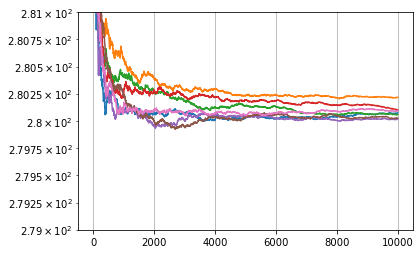

In [330]:
plt.figure()
plt.plot(np.cumsum(loss1)/[1+t for t in range(T)])
plt.plot(np.cumsum(loss2)/[1+t for t in range(T)])
plt.plot(np.cumsum(loss3)/[1+t for t in range(T)])
plt.plot(np.cumsum(loss4)/[1+t for t in range(T)])
plt.plot(np.cumsum(loss5)/[1+t for t in range(T)])
plt.plot(np.cumsum(loss6)/[1+t for t in range(T)])
plt.plot(np.cumsum(loss7)/[1+t for t in range(T)])
#plt.plot(np.cumsum(loss8)/[1+t for t in range(T)])
#plt.plot(np.cumsum(loss9)/[1+t for t in range(T)])
plt.yscale('log')
plt.grid()
plt.ylim(2.79e2,2.81e2)

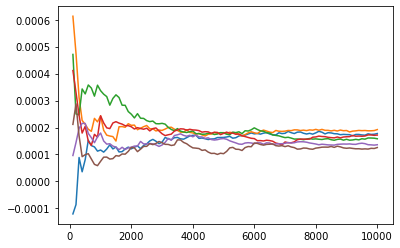

In [337]:
i = 0

est = np.var(thetaMALA[1000:,:],axis=0)[i]

N = 100
Tbi = 0
TT = [int(((T-Tbi)/N) * (k+1) + Tbi) for k in range(N)]

plt.figure()
plt.plot(TT,[np.var(theta1[0,Tbi:t,:],axis=0)[i] - est for t in TT])
plt.plot(TT,[np.var(theta2[0,Tbi:t,:],axis=0)[i] - est for t in TT])
plt.plot(TT,[np.var(theta3[0,Tbi:t,:],axis=0)[i] - est for t in TT])
plt.plot(TT,[np.var(theta4[0,Tbi:t,:],axis=0)[i] - est for t in TT])
plt.plot(TT,[np.var(theta5[0,Tbi:t,:],axis=0)[i] - est for t in TT])
#plt.plot(TT,[np.var(theta6[0,Tbi:t,:],axis=0)[i] - est for t in TT])

#plt.plot(TT,[np.var(theta5[0,0:t,:],axis=0)[i] - est for t in TT])
#plt.plot(TT,[np.var(theta6[0,0:t,:],axis=0)[i] - est for t in TT])
plt.plot(TT,[np.var(theta7[0,Tbi:t,:],axis=0)[i] - est for t in TT])

i = 0

est = np.var(thetaMALA[100000:,:],axis=0)[i]

N = 100
Tbi = 100
TT = [int(((T-Tbi)/N) * (k+1) + Tbi) for k in range(N)]

plt.figure()
plt.plot(TT,[np.var(theta1[0:2,Tbi:t,:],axis=1)[:,i] - est for t in TT])
plt.plot(TT,[np.var(theta2[0:2,Tbi:t,:],axis=1)[:,i] - est for t in TT])
plt.plot(TT,[np.var(theta3[0:2,Tbi:t,:],axis=1)[:,i] - est for t in TT])
#plt.plot(TT,[np.var(theta4[0:2,Tbi:t,:],axis=1)[:,i] - est for t in TT])
#plt.plot(TT,[np.var(theta5[0,0:t,:],axis=0)[i] - est for t in TT])
#plt.plot(TT,[np.var(theta6[0,0:t,:],axis=0)[i] - est for t in TT])
plt.plot(TT,[np.var(theta7[0,Tbi:t,:],axis=0)[i] - est for t in TT])

In [306]:
idx1 = 0
idx2 = 2

est_true = np.var(thetaMALA[50000:,:],axis=0)[idx1:idx2]
#T = 50000
Tbi = 0

N = 100
Tbi = 0
TT = [int(((T-Tbi)/N) * (k+1) + Tbi) for k in range(N)]

mse1 = np.zeros(len(TT))
mse2 = np.zeros(len(TT))
mse3 = np.zeros(len(TT))
mse4 = np.zeros(len(TT))
mse5 = np.zeros(len(TT))
mse6 = np.zeros(len(TT))
mse7 = np.zeros(len(TT))
mse8 = np.zeros(len(TT))


for t in range(len(TT)):
    # SGLDFP
    est = np.mean(theta1[:,Tbi:TT[t],:],axis=1)[idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse1[t] = Bias2 + Var
    
    # Q-ULA 1
    est = np.mean(theta2[:,Tbi:TT[t],:],axis=1)[idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse2[t] = Bias2 + Var
    
    # Q-ULA 2
    est = np.mean(theta3[:,Tbi:TT[t],:],axis=1)[idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse3[t] = Bias2 + Var
    
    # Q-ULA 3
    est = np.mean(theta4[:,Tbi:TT[t],:],axis=1)[idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse4[t] = Bias2 + Var
    
    # Q-ULA 4
    est = np.mean(theta5[:,Tbi:TT[t],:],axis=1)[idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse5[t] = Bias2 + Var
    
    # Q-UL
    est = np.mean(theta6[:,Tbi:TT[t],:],axis=1)[idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse6[t] = Bias2 + Var
    
    # Q-ULA 4
    est = np.mean(theta7[:,Tbi:TT[t],:],axis=1)[idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse7[t] = Bias2 + Var

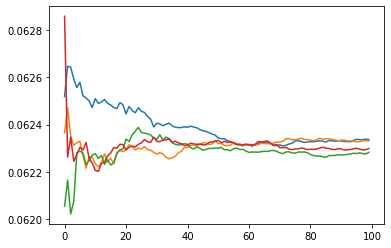

In [314]:
plt.plot(mse1)
plt.plot(mse2)
plt.plot(mse3)
plt.plot(mse4)
#plt.plot(mse5)
#plt.plot(mse8)
#plt.plot(mse1)

ValueError: x is required to have ndim 1 but has ndim 2

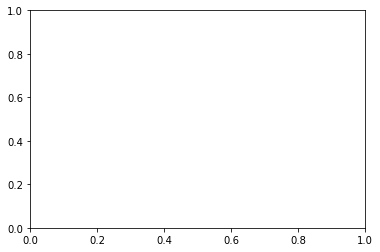

In [310]:
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(theta1[:,0], lags=1000)
plt.show()

In [ ]:
def MALA(T_total,T_bi,T,gamma,init):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    
    # Initialisation
    theta[0,:] = init
    x = theta[0,:]
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (tau/2) * np.linalg.norm(x)**2
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        P = 1 / (1 + np.exp(np.dot(X_tot,x)))
        grad = -np.dot(X_tot.T, np.reshape(P - y_tot,(np.sum(n),))) + tau * x
        grad = np.reshape(grad,(d,))
        s = np.zeros(d)
        s = x - gamma * grad + np.sqrt(2*gamma) * np.random.normal(0,1,d)
    
        
        u = np.random.uniform()
        U = np.sum(y_tot * np.dot(X_tot,s)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,s)))) \
                                           + (tau/2) * np.linalg.norm(s)**2
        U_old = np.sum(y_tot * np.dot(X_tot,x)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,x)))) \
                                           + (tau/2) * np.linalg.norm(x)**2
        P = 1 / (1 + np.exp(np.dot(X_tot,s)))
        grad_prop = -np.dot(X_tot.T, np.reshape(P - y_tot,(np.sum(n),1))) + tau * s
        grad_prop = np.reshape(grad,(d,))
        ratio = np.exp(-U + U_old \
                       - (1/(4*gamma))*np.linalg.norm(x - s + gamma * grad_prop,2)**2 \
                       + (1/(4*gamma))*np.linalg.norm(s - x + gamma * grad,2)**2)
        print(min(1,ratio))
        if u <= ratio:
            x = s
          
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,x)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,x)))) \
                                           + (tau/2) * np.linalg.norm(x)**2
            
            # Accuracy
            a = np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])) / (1 + np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
        
        if t % 100000 == 0:
            print(t)
            
    return theta, loss, acc
    


def QLSD_star(T_total,T_bi,T,gamma,p,init,s,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(x))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(X[i],z)))
            fullgrad_z = np.dot(X[i].T, np.reshape(y[i] - P,(n[i],))) + alpha * (1/np.sum(n)) * np.dot(X[i].T,X[i]).dot(z)
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = -(1 / (1 + np.exp(np.dot(X[i][idx,:],x))) - y[i][idx]) * X[i][idx,:] \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  x
            grad_z = -(1 / (1 + np.exp(np.dot(X[i][idx,:],z))) - y[i][idx]) * X[i][idx,:] \
                     + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  z
            grad = n[i] * (grad_theta - grad_z) + fullgrad_z

            # Quantize the stochastic gradient
            qgrad[i,:] = SQuantization(s, grad)

            
                
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = - np.dot(y_tot,np.log(P)) \
                                           - np.dot(1-y_tot,np.log(1-P)) \
                                           + (alpha/2) * np.linalg.norm(B.dot(x))**2
            
            # Accuracy
            a = np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])) / (1 + np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
            
    return theta, loss, acc



def precondQLSD_star(T_total,T_bi,T,gamma,p,init,s,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    grad = np.zeros((b,d))
    gradnorm = np.zeros((T))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(-np.dot(Xprec[i],z)))
            fullgrad_z = -np.dot(Xprec[i].T, np.reshape(y[i]-P,(n[i],))) + (alpha * (n[i]/np.sum(n))) * z
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = -(y[i][idx] - 1 / (1 + np.exp(-np.dot(Xprec[i][idx,:],x)))) * Xprec[i][idx,:] \
                         + (alpha * (1/np.sum(n))) * x
            grad_z = -(y[i][idx] - 1 / (1 + np.exp(-np.dot(Xprec[i][idx,:],z)))) * Xprec[i][idx,:] \
                     + (alpha * (1/np.sum(n))) * z
            grad[i,:] = n[i] * (grad_theta - grad_z) + fullgrad_z

            # Quantize the stochastic gradient
            qgrad[i,:] = SQuantization(s, grad[i,:])
            
            
        
        
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = A.dot(x)
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,A.dot(x))) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,A.dot(x))))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(A.dot(x)))**2
            
            # Store grad norm
            gradnorm[int((t-T_bi)/thin) + 1] = np.linalg.norm(np.sum(grad,axis=0))
            
    return theta, loss, gradnorm



def precondQLSDpp(T_total,T_bi,T,gamma,p,init,s,K,beta,memory=True):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    h = np.zeros((b,d))
    gradnorm = np.zeros((T))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(-np.dot(Xprec[i],z)))
            fullgrad_z = -np.dot(Xprec[i].T, np.reshape(y[i]-P,(n[i],))) + (alpha * (n[i]/np.sum(n))) * z
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = -(y[i][idx] - 1 / (1 + np.exp(-np.dot(Xprec[i][idx,:],x)))) * Xprec[i][idx,:] \
                         + (alpha * (1/np.sum(n))) * x
            grad_z = -(y[i][idx] - 1 / (1 + np.exp(-np.dot(Xprec[i][idx,:],z)))) * Xprec[i][idx,:] \
                     + (alpha * (1/np.sum(n))) * z
            grad = n[i] * (grad_theta - grad_z) + fullgrad_z

            # Quantize the stochastic gradient minus memory term
            qqgrad = SQuantization(s, grad - h[i,:])
            qgrad[i,:] = qqgrad + h[i,:]
            if memory == True:
                h[i,:] = h[i,:] + beta * qqgrad   
        
        
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = A.dot(x)
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,A.dot(x))) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,A.dot(x))))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(A.dot(x)))**2
            
            # Store grad norm
            gradnorm[int((t-T_bi)/thin) + 1] = np.linalg.norm(np.sum(grad,axis=0))
            
    return theta, loss, gradnorm

def QLSDpp(T_total,T_bi,T,gamma,p,init,s,K,beta):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    h = np.zeros((b,d))
    gradnorm = np.zeros((T))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(X[i],z)))
            fullgrad_z = np.dot(X[i].T, np.reshape(y[i] - P,(n[i],))) + alpha * (1/np.sum(n)) * np.dot(X[i].T,X[i]).dot(z)
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i],size=int(0.2*n[i]))
            grad_theta = -(1 / (1 + np.exp(np.dot(X[i][idx,:],x))) - y[i][idx]).dot(X[i][idx,:]) \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]).dot(x)
            grad_z = -(1 / (1 + np.exp(np.dot(X[i][idx,:],z))) - y[i][idx]).dot(X[i][idx,:]) \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]).dot(z)
            grad = 1/0.2 * (grad_theta - grad_z) + fullgrad_z

            # Quantize the stochastic gradient minus memory term
            qqgrad = SQuantization(s, grad - h[i,:])
            qgrad[i,:] = qqgrad + h[i,:]
            h[i,:] = h[i,:] + beta * qqgrad   
        
        
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,x)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,x)))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(x))**2
            
            # Store grad norm
            gradnorm[int((t-T_bi)/thin) + 1] = np.linalg.norm(np.sum(grad,axis=0))
            
    return theta, loss, gradnorm

def QLSDpp_withoutmemory(T_total,T_bi,T,gamma,p,init,s,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    h = np.zeros((b,d))
    gradnorm = np.zeros((T))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
             # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(X[i],z)))
            fullgrad_z = np.dot(X[i].T, np.reshape(y[i] - P,(n[i],))) + alpha * (1/np.sum(n)) * np.dot(X[i].T,X[i]).dot(z)
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i],size=int(0.2*n[i]))
            grad_theta = -(1 / (1 + np.exp(np.dot(X[i][idx,:],x))) - y[i][idx]).dot(X[i][idx,:]) \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]).dot(x)
            grad_z = -(1 / (1 + np.exp(np.dot(X[i][idx,:],z))) - y[i][idx]).dot(X[i][idx,:]) \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]).dot(z)
            grad = 1/0.2 * (grad_theta - grad_z) + fullgrad_z

            # Quantize the stochastic gradient minus memory term
            qqgrad = SQuantization(s, grad - h[i,:])
            qgrad[i,:] = qqgrad + h[i,:]   
        
        
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,x)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,x)))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(x))**2
            
            # Store grad norm
            gradnorm[int((t-T_bi)/thin) + 1] = np.linalg.norm(np.sum(grad,axis=0))
            
    return theta, loss, gradnorm



def precondQSD_star(T_total,T_bi,T,gamma,p,init,s,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    grad = np.zeros((b,d))
    gradnorm = np.zeros((T))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(Xprec[i],z)))
            fullgrad_z = np.dot(Xprec[i].T, np.reshape(y[i]-P,(n[i],))) + (alpha * (n[i]/np.sum(n))) * z
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = (y[i][idx] - 1 / (1 + np.exp(np.dot(Xprec[i][idx,:],x)))) * Xprec[i][idx,:] \
                         + (alpha * (1/np.sum(n))) * x
            grad_z = (y[i][idx] - 1 / (1 + np.exp(np.dot(Xprec[i][idx,:],z)))) * Xprec[i][idx,:] \
                     + (alpha * (1/np.sum(n))) * z
            grad[i,:] = n[i] * (grad_theta - grad_z) + fullgrad_z

            # Quantize the stochastic gradient
            qgrad[i,:] = SQuantization(s, grad[i,:])
            
            
        
        
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) 
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = A.dot(x)
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,A.dot(x))) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,A.dot(x))))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(A.dot(x)))**2
            
            # Store grad norm
            gradnorm[int((t-T_bi)/thin) + 1] = np.linalg.norm(np.sum(grad,axis=0))
            
    return theta, loss, gradnorm

def precondLSD_star(T_total,T_bi,T,gamma,p,init,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    grad = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(Xprec[i],z)))
            fullgrad_z = np.dot(Xprec[i].T, np.reshape(y[i]-P,(n[i],))) + (alpha * (n[i]/np.sum(n))) * z
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = (y[i][idx] - 1 / (1 + np.exp(np.dot(Xprec[i][idx,:],x)))) * Xprec[i][idx,:] \
                         + (alpha * (1/np.sum(n))) * x
            grad_z = (y[i][idx] - 1 / (1 + np.exp(np.dot(Xprec[i][idx,:],z)))) * Xprec[i][idx,:] \
                     + (alpha * (1/np.sum(n))) * z
            grad[i,:] = n[i] * (grad_theta - grad_z) + fullgrad_z
            
                
        # Update theta on server
        x = x - gamma * np.sum(grad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = A.dot(x)
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,A.dot(x))) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,A.dot(x))))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(A.dot(x)))**2
            
    return theta, loss


def LSD_star(T_total,T_bi,T,gamma,p,init,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    grad = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(X[i],z)))
            fullgrad_z = -np.dot(X[i].T, np.reshape(P - y[i],(n[i],))) + alpha * (1/np.sum(n)) * np.dot(X[i].T,X[i]).dot(z)
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = -(1 / (1 + np.exp(np.dot(X[i][idx,:],x))) - y[i][idx]) * X[i][idx,:] \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  x
            grad_z = -(1 / (1 + np.exp(np.dot(X[i][idx,:],z))) - y[i][idx]) * X[i][idx,:] \
                     + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  z
            grad[i,:] = n[i] * (grad_theta - grad_z) + fullgrad_z
                         
        # Update theta on server
        x = x - gamma * np.sum(grad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,x)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,x)))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(x))**2
            
            # Accuracy
            a = np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])) / (1 + np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
            
    return theta, loss, acc

def ULA(T_total,T_bi,T,gamma,init):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    
    # Initialisation
    theta[0,:] = init
    x = theta[0,:]
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(x))**2
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        P = 1 / (1 + np.exp(np.dot(X_tot,x)))
        grad = -np.dot(X_tot.T, np.reshape(P - y_tot,(np.sum(n),))) + alpha * B.T.dot(B.dot(x))
        grad = np.reshape(grad,(d,))
        x = x - gamma * grad + np.sqrt(2*gamma) * np.random.normal(0,1,d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,x)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,x)))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(x))**2
            
            # Accuracy
            a = np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])) / (1 + np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
        
        if t % 100000 == 0:
            print(t)
            
    return theta, loss, acc

In [ ]:
alpha = (3 * d) / np.pi**2 # parameter of the Zellner prior

# Define new observation matrices X for preconditioned versions of (Q)LSD
w, v = np.linalg.eig(SigmaX)
w = np.max(w.real)
M = w * (np.sum(n)/4 + alpha)
Mprec = np.sum(n)/4 + alpha
T = 1000
K = 100
gamma = 5/M
gammaprec = 1/(Mprec)
init = np.ones(d)
S = [2**2,2**4,2**8]
Omega = [np.minimum(d/s**2,np.sqrt(d)/s) for s in S]

# Repetitions
rep = 1

# Init.
theta1 = np.zeros((rep,T,d))
theta2 = np.zeros((rep,T,d))
theta3 = np.zeros((rep,T,d))
theta4 = np.zeros((rep,T,d))
theta5 = np.zeros((rep,T,d))
theta6 = np.zeros((rep,T,d))
theta7 = np.zeros((rep,T,d))
theta8 = np.zeros((rep,T,d))


for r in range(rep):
    #theta1[r,:], loss1, g1 = precondQLSDpp(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,s=2**1,K=K,
    #                                      beta = 1/(Omega[0]+1),memory=False)
    #theta2[r,:], loss2, g2 = precondQLSDpp(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,s=2**1,K=K,
    #                                      beta = 1/(Omega[0]+1))
    theta3[r,:], loss3, g3 = precondQLSD_star(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,s=2**2,K=K)
    theta4[r,:], loss4, g3 = precondQLSDpp(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,s=2**2,K=K,
                                          beta=1/(Omega[0]+1),memory=True)
   #theta5[r,:], loss5, g4 = precondQLSD_star(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,s=2**8,K=K)
    #theta6[r,:], loss6, g5 = precondQLSDpp(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,s=2**8,K=K,
    #                                      beta = 1/(Omega[2]+1))
    #theta7[r,:], loss7, g6 = precondQLSD_star(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,s=2**16,K=K)
    theta8[r,:], loss8 = precondLSD_star(T_total=T,T_bi=0,T=T,gamma=gammaprec,p=0.1,init=init,K=K)
    #theta9, loss9 = precondLSD_star(T_total=T,T_bi=0,T=T,gamma=0.1*gammaprec,p=0.1,init=init,K=K)
    
    print(r)

In [ ]:
plt.plot(np.cumsum(loss3)/np.array(range(T)))
plt.plot(np.cumsum(loss4)/np.array(range(T)))
#plt.plot(np.cumsum(loss3)/np.array(range(T)))
#plt.plot(np.cumsum(loss4)/np.array(range(T)))
#plt.plot(np.cumsum(loss5)/np.array(range(T)))
#plt.plot(np.cumsum(loss6)/np.array(range(T)))
#plt.plot(np.cumsum(loss7)/np.array(range(T)))
plt.plot(np.cumsum(loss8)/np.array(range(T)))
#plt.plot(np.cumsum(loss9)/np.array(range(T)))
plt.yscale('log')
plt.grid()
#plt.ylim(7e2,1.2e3)

In [ ]:
plt.loglog(loss3)
plt.loglog(loss4)
plt.loglog(loss8)
#plt.loglog(loss4)
#plt.loglog(loss9)

In [ ]:
idx1 = 0
idx2 = 2

est_true = np.var(theta9[1000:,:],axis=0)[idx1:idx2]
#T = 50000
Tbi = 0

N = 100
Tbi = 0
TT = [int(((T-Tbi)/N) * (k+1) + Tbi) for k in range(N)]

mse1 = np.zeros(len(TT))
mse2 = np.zeros(len(TT))
mse3 = np.zeros(len(TT))
mse4 = np.zeros(len(TT))
mse5 = np.zeros(len(TT))
mse6 = np.zeros(len(TT))
mse7 = np.zeros(len(TT))
mse8 = np.zeros(len(TT))


for t in range(len(TT)):
    # SGLDFP
    est = np.var(theta1[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse1[t] = Bias2 + Var
    
    # Q-ULA 1
    est = np.var(theta2[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse2[t] = Bias2 + Var
    
    # Q-ULA 2
    est = np.var(theta3[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse3[t] = Bias2 + Var
    
    # Q-ULA 3
    est = np.var(theta4[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse4[t] = Bias2 + Var
    
    # Q-ULA 4
    est = np.var(theta5[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse5[t] = Bias2 + Var
    
    # Q-UL
    est = np.var(theta6[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse6[t] = Bias2 + Var
    
    # Q-ULA 4
    est = np.var(theta7[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse7[t] = Bias2 + Var
    
    # Q-ULA 4
    est = np.var(theta8[:,Tbi:TT[t],:],axis=1)[:,idx1:idx2]
    Bias2 = np.linalg.norm(np.mean(est,0) - est_true)**2
    Var = np.mean((np.mean(est,0) - est)**2)
    mse8[t] = Bias2 + Var

In [ ]:
d

In [ ]:
plt.figure()
plt.plot(TT,mse1)
plt.plot(TT,mse2)
plt.plot(TT,mse3)
plt.plot(TT,mse4)
plt.plot(TT,mse5)
plt.plot(TT,mse6)
#plt.yscale('log')
plt.xscale('log')
plt.grid()

plt.figure()
plt.plot([b*com_bits(1,d)*(TT[t] - Tbi) for t in range(len(TT))],mse1,lw=2,label="QLSD 2 bits")
plt.plot([b*com_bits(2**4,d)*(TT[t] - Tbi) for t in range(len(TT))],mse2,lw=2,label="QLSD 2 bits")
#plt.plot([b*com_bits(2**4,d)*(TT[t] - Tbi) for t in range(len(TT))],mse3,lw=2,label="QLSD 4 bits")
#plt.plot([b*com_bits(2**8,d)*(TT[t] - Tbi) for t in range(len(TT))],mse4,lw=2,label="QLSD 8 bits")
#plt.plot([b*com_bits(2**16,d)*(TT[t] - Tbi) for t in range(len(TT))],mse5,lw=2,label="QLSD 16 bits")
#plt.plot([b*32*d*(TT[t] - Tbi) for t in range(len(TT))],mse6,lw=2,label="LSD")
plt.xscale('log')
#plt.yscale('log')
plt.grid(True, which="both", ls="-",linewidth=0.4)

In [ ]:
plt.plot(acc1)
plt.plot(acc2)
plt.plot(acc3)
plt.plot(acc5)
plt.plot(acc6)
#plt.plot(acc7)
plt.xscale('log')

## 1. Binomial logistic regression on Vehicle dataset

#### Global parameters

In [ ]:
b = 23 # number of clients
d = 100 # number of features
tau = 1 # regularization parameter
alpha = (3 * d) / np.pi**2 # parameter of the Zellner prior

#### Generate data

In [ ]:
# preprocess data (x-mean)/stdev
def preprocess(x):
    means = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    
    x = (x - means) * 1.0 / std
    where_are_NaNs = isnan(x)
    x[where_are_NaNs] = 0
    return x

def generate_data():
    X = []
    y = []
    mat = scipy.io.loadmat('vehicle.mat')
    raw_x, raw_y = mat['X'], mat['Y']

    
    for i in range(b):
        X.append(preprocess(raw_x[i][0]).tolist())
        y.append(raw_y[i][0].tolist())
        num = 0
        for j in range(len(raw_y[i][0])):
            if raw_y[i][0][j] == 1:
                num += 1
    return X, y
    

train_data = {'users': [], 'user_data':{}, 'num_samples':[]}
test_data = {'users': [], 'user_data':{}, 'num_samples':[]}


X, y = generate_data()

    
# Create data structure
train_data = {'users': [], 'user_data':{}, 'num_samples':[]}
test_data = {'users': [], 'user_data':{}, 'num_samples':[]}
    
for i in range(b):

    uname = 'f_{0:05d}'.format(i)        
    combined = list(zip(X[i], y[i]))
    np.random.seed(1994)
    np.random.shuffle(combined)
    X[i][:], y[i][:] = zip(*combined)
    num_samples = len(X[i])
    train_len = int(0.75 * num_samples) # the percentage of training samples is 0.75 (in order to be consistant with the statistics shown in the MTL paper)
    test_len = num_samples - train_len
        
    train_data['users'].append(uname) 
    train_data['user_data'][uname] = {'x': X[i][:train_len], 'y': y[i][:train_len]}
    train_data['num_samples'].append(train_len)
    test_data['users'].append(uname)
    test_data['user_data'][uname] = {'x': X[i][train_len:], 'y': y[i][train_len:]}
    test_data['num_samples'].append(test_len)

#### Display data distribution

In [ ]:
n = np.zeros(b)
for i in range(b):
    n[i] = np.size(train_data['user_data'][train_data['users'][i]]['x'],0)
n = n.astype(int)
plt.figure()
plt.bar(range(b),n)
plt.xlabel(r'Client $i$',size=15)
plt.ylabel(r'Number of observations $N_i$',size=15)
plt.title(r'Vehicle dataset',size=15)

#### Preprocessing

In [ ]:
# Define the observations vector y
y = []
for i in range(b):
    a = np.reshape(train_data['user_data'][train_data['users'][i]]['y'],(n[i],))
    a[a == -1] = 0
    y.append(a)
    
# Define the observation matrix X
X = []
for i in range(b):
    a = np.reshape(train_data['user_data'][train_data['users'][i]]['x'],(n[i],d))
    X.append(a)
    
# Define total observations and features
y_tot = np.concatenate(y,axis=0)
X_tot = np.concatenate(X,axis=0)

# Define new observation matrices X for preconditioned versions of (Q)LSD
SigmaX = X_tot.T.dot(X_tot) / np.sum(n)
U, S, V = np.linalg.svd(SigmaX, full_matrices=True,hermitian=True)
A = U.dot(np.diag(S**(-1/2))).dot(U.T)
B = U.dot(np.diag(S**(1/2))).dot(U.T)
Xprec_tot = X_tot.dot(A)

Xprec = []
for i in range(b):
    if i==0:
        a = Xprec_tot[0:n[i],:]
    else:
        a = Xprec_tot[n[i-1]:n[i-1]+n[i],:]
    Xprec.append(a)

#### Algorithms

In [ ]:
def QLSD_star(T_total,T_bi,T,gamma,p,init,s,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(x))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(-np.dot(X[i],z)))
            fullgrad_z = np.dot(X[i].T, np.reshape(P - y[i],(n[i],))) + alpha * (1/np.sum(n)) * np.dot(X[i].T,X[i]).dot(z)
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = (1 / (1 + np.exp(-np.dot(X[i][idx,:],x))) - y[i][idx]) * X[i][idx,:] \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  z
            grad_z = (1 / (1 + np.exp(-np.dot(X[i][idx,:],z))) - y[i][idx]) * X[i][idx,:] \
                     + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  z
            grad = grad_theta - grad_z + fullgrad_z

            # Quantize the stochastic gradient
            qgrad[i,:] = SQuantization(s, grad)
            
                
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = - np.dot(y_tot,np.log(P)) \
                                           - np.dot(1-y_tot,np.log(1-P)) \
                                           + (alpha/2) * np.linalg.norm(B.dot(x))**2
            
            # Accuracy
            a = np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])) / (1 + np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
            
    return theta, loss, acc



def precondQLSD_star(T_total,T_bi,T,gamma,p,init,s,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    theta = np.zeros((T,d))
    qgrad = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(Xprec[i],z)))
            fullgrad_z = np.dot(Xprec[i].T, np.reshape(y[i]-P,(n[i],))) + (alpha * (n[i]/np.sum(n))) * z
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = (y[i][idx] - 1 / (1 + np.exp(np.dot(Xprec[i][idx,:],x)))) * Xprec[i][idx,:] \
                         + (alpha * (1/np.sum(n))) * x
            grad_z = (y[i][idx] - 1 / (1 + np.exp(np.dot(Xprec[i][idx,:],z)))) * Xprec[i][idx,:] \
                     + (alpha * (1/np.sum(n))) * z
            grad = grad_theta - grad_z + fullgrad_z

            # Quantize the stochastic gradient
            qgrad[i,:] = SQuantization(s, grad)
            
                
        # Update theta on server
        x = x - gamma * np.sum(qgrad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = A.dot(x)
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,A.dot(x))) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,A.dot(x))))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(A.dot(x)))**2
            
    return theta, loss


def LSD_star(T_total,T_bi,T,gamma,p,init,K):
    
    # Definition of the arrays of interest
    loss = np.zeros(T)
    acc = np.zeros(T)
    theta = np.zeros((T,d))
    grad = np.zeros((b,d))
    
    # Initialisation
    theta[0,:] = init
    x = init
    P = 1 / (1 + np.exp(-np.dot(X_tot,theta[0,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    loss[0] = - np.dot(y_tot,np.log(P)) - np.dot(1-y_tot,np.log(1-P)) + (alpha/2) * np.linalg.norm(B.dot(theta[0,:]))**2
    z = theta[0,:]
    
    # Parameters
    thin = int((T_total-T_bi+1)/T)

    # MCMC sampler    
    for t in range(T_total-1): # total number of iterations
        
        if t % K == 0: # update of the control variate every K iterations
            z = x

        for i in range(b): # for each client in parallel
            
            # Compute full gradient at control variate
            P = 1 / (1 + np.exp(np.dot(X[i],z)))
            fullgrad_z = -np.dot(X[i].T, np.reshape(P - y[i],(n[i],))) + alpha * (1/np.sum(n)) * np.dot(X[i].T,X[i]).dot(z)
            fullgrad_z = np.reshape(fullgrad_z,(d,))

            # Compute stochastic gradient based on SVRG scheme
            idx = np.random.randint(0, n[i])
            grad_theta = -(1 / (1 + np.exp(np.dot(X[i][idx,:],x))) - y[i][idx]) * X[i][idx,:] \
                         + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  x
            grad_z = -(1 / (1 + np.exp(np.dot(X[i][idx,:],z))) - y[i][idx]) * X[i][idx,:] \
                     + alpha * (1/np.sum(n)) * np.dot(X[i][idx,:].T,X[i][idx,:]) *  z
            grad[i,:] = grad_theta - grad_z + fullgrad_z
                         
        # Update theta on server
        x = x - gamma * np.sum(grad,axis=0) + np.sqrt(2*gamma) * np.random.normal(0,1,size=d)
    
        # Save theta according to the thinning strategy
        if (t % thin == 0) and (t >= T_bi):
            theta[int((t-T_bi)/thin) + 1,:] = x
            P = 1 / (1 + np.exp(-np.dot(X_tot,x)))
            P = P - 1e-5
            P[P<0] = 1e-10
            loss[int((t-T_bi)/thin) + 1] = np.sum(y_tot * np.dot(X_tot,x)) \
                                           + np.sum(np.log(1 + np.exp(-np.dot(X_tot,x)))) \
                                           + (alpha/2) * np.linalg.norm(B.dot(x))**2
            
            # Accuracy
            a = np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])) / (1 + np.exp(X_tot.dot(theta[int((t-T_bi)/thin) + 1,:])))
            a[a >= 0.5] = 1
            a[a < 0.5] = 0
            err = np.sum(np.abs(a - y_tot))/len(y_tot)
            acc[int((t-T_bi)/thin) + 1] = 1 - err
            
    return theta, loss, acc

In [ ]:
w, v = np.linalg.eig(SigmaX)
w = np.max(w.real)
M = w * (np.sum(n)/4 + alpha)
Mprec = np.sum(n)/4 + alpha
m = tau
kappa = M/m
T = 10000
K = 1
gamma = 1/M
gammaprec = 1/M

theta1, loss1, acc1 = QLSD_star(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=1,K=K)
theta2, loss2, acc2 = QLSD_star(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=2**1,K=K)
theta3, loss3, acc3 = QLSD_star(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=2**2,K=K)
theta4, loss4, acc4 = QLSD_star(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=2**4,K=K)
theta5, loss5, acc5 = QLSD_star(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=2**8,K=K)
theta6, loss6, acc6 = QLSD_star(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),s=2**16,K=K)
theta7, loss7, acc7 = LSD_star(T_total=T,T_bi=0,T=T,gamma=gamma,p=0.01,init=np.zeros(d),K=K)

In [ ]:
plt.figure()
plt.plot(loss1,label=r"QLSD $s=1$")
plt.plot(loss2,label=r"QLSD $s=2^1$")
plt.plot(loss3,label=r"QLSD $s=2^2$")
plt.plot(loss4,label=r"QLSD $s=2^4$")
plt.plot(loss5,label=r"QLSD $s=2^8$")
plt.plot(loss6,label=r"QLSD $s=2^{16}$")
plt.plot(loss7,label=r"LSD")
plt.legend()
plt.xlabel('Number of communication rounds',size=15)
plt.ylabel('Neg. log. posterior',size=15)
plt.grid()
plt.ylim(1.04e4,1.07e4)

In [ ]:
#plt.plot(acc1)
#plt.plot(acc2)
plt.plot(acc6)
plt.grid()

In [ ]:
a = np.exp(X_tot.dot(np.mean(theta1[2000:,:],0))) / (1 + np.exp(X_tot.dot(np.mean(theta1[2000:,:],0))))
a[a >= 0.5] = 1
a[a < 0.5] = 0
err = np.sum(np.abs(a - y_tot))/len(y_tot)
acc = 1 - err
acc

#### Load EMNIST raw data

In [ ]:
train_dataset = EMNIST('./data', split="digits", train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))]))
test_dataset = EMNIST('./data', split="digits", train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))]))

#### Function to sample non-iid client data from EMNIST dataset

In [ ]:
def femnist_star(dataset, num_users):
    """
        Sample non-IID client data from EMNIST dataset -> FEMNIST*
        :param dataset:
        :param num_users:
        :return: dict of image index
    """
    print("Sampling dataset: FEMNIST*")
    np.random.seed(1994)

    dict_users = {i: [] for i in range(num_users)}
    total_len = len(dataset)

    labels = dataset.targets.numpy()
    idxs = np.argsort(labels)

    num_shards, num_imgs = 26 * num_users, total_len // (num_users * 26)

    label_selected = [np.random.choice(26, 20, replace=False) for _ in range(num_users)]

    label_selected_1 = [np.random.choice(label_selected[i], 6, replace=False) for i in range(num_users)]
    for i in range(num_users):
        for j in label_selected[i]:
            ind_pos = np.random.choice(num_users)
            tmp = copy.deepcopy(idxs[j * num_users * num_imgs + ind_pos * num_imgs: j * num_users * num_imgs + (ind_pos + 1) * num_imgs])
            dict_users[i].append(tmp)
        for j in label_selected_1[i]:
            ind_pos = np.random.choice(num_users)
            tmp = copy.deepcopy(idxs[j * num_users * num_imgs + ind_pos * num_imgs: j * num_users * num_imgs + (
                        ind_pos + 1) * num_imgs])
            dict_users[i].append(tmp)

    for i in range(num_users):
        dict_users[i] = np.concatenate(tuple(dict_users[i]), axis=0)
    return dict_users

#### Parameters

Note that the size of the training dataset is 240,000. Hence, $b\cdot n_{max}$ should be lesser than 240,000.

In [ ]:
b = 10 # number of clients
n_max = 200 # maximum number of observations on each client
n_min = 20 # minimum number of observations on each client
np.random.seed(1994)
n = np.random.randint(low=n_min,high=n_max,size=b) # number of observations per client

#### Build the federated learning dataset

In [ ]:
dict_users = femnist_star(train_dataset,b)
X = []
labels = []
for i in range(b):
    np.random.seed(1994)
    idx_client = np.random.choice(dict_users[i],n[i],replace=False)
    X.append([train_dataset[i][0] for i in idx_client])
    labels.append([train_dataset[i][1] for i in idx_client])

#### Algorithms

In [ ]:
d = 28*28
XX = np.concatenate(X,axis=0)
X_tot = np.zeros((len(XX),d))
for n in range(len(XX)):
    X_tot[n,:] = np.reshape(XX[n],(d,))

y = np.concatenate(labels,axis=0)
X = X_tot

In [ ]:
# Parameters
K = 10
tau = 1
w, v = np.linalg.eig(np.dot(X.T,X))
w = np.max(w.real)
M = w * (1/4) + tau 
gamma = 0.001/M
T = 10000

# Initialization
theta_MALA = np.zeros((T,d,K))
U_MALA = np.zeros(T)
accuracy = np.zeros(T)

loss = 0
for k in range(K):
    idx = np.where(y == k)
    A = np.reshape(np.exp(np.dot(X[idx,:],theta_MALA[0,:])),(np.size(idx),K))
    loss = loss + np.sum(np.log(np.sum(A,axis=1)) - np.dot(X[idx,:],theta_MALA[0,:,k]))
        
U_MALA[0] = loss + (tau/2) * np.sum(np.linalg.norm(theta_MALA[0,:],axis=0)**2) 

for t in range(T-1):

    for k in range(K):
        idx = np.where(y == k)
        A = np.reshape(np.exp(np.dot(X[idx,:],theta_MALA[t,:])),(np.size(idx),K))
        P = np.exp(np.dot(X[idx,:],theta_MALA[t,:,k])) / np.sum(A,axis=1)
        grad = np.dot(np.reshape(X[idx,:],(np.size(idx),d)).T, np.reshape(P - 1,(np.size(idx),))) + tau * theta_MALA[t,:,k]
        grad = np.reshape(grad,(d,))
        theta_MALA[t+1,:,k] = theta_MALA[t,:,k] - gamma * grad + np.sqrt(2*gamma) * np.random.normal(0,1,d)        
        
    # Compute the loss
    loss = 0
    for k in range(K):
        idx = np.where(y == k)
        A = np.reshape(np.exp(np.dot(X[idx,:],theta_MALA[t+1,:])),(np.size(idx),K))
        loss = loss + np.sum(np.log(np.sum(A,axis=1)) - np.dot(X[idx,:],theta_MALA[t+1,:,k]))
        
    U_MALA[t+1] = loss + (tau/2) * np.sum(np.linalg.norm(theta_MALA[t+1,:],axis=0)**2)
    
    # Compute the accuracy of train set
    proba = np.zeros((len(y),K))
    A = np.reshape(np.exp(np.dot(X,theta_MALA[t+1,:])),(len(y),K))
    for k in range(K):
        proba[:,k] = np.exp(np.dot(X,theta_MALA[t+1,:,k])) / np.sum(A,axis=1)
        
    err = proba.argmax(axis=1) - y
    err[err != 0] = 1
    accuracy[t+1] = 1 - np.sum(err)/len(err)

In [ ]:
plt.plot(accuracy)
plt.grid()

In [ ]:
plt.loglog(U_MALA)
plt.grid()

In [ ]:
P = np.exp(-np.dot(X[idx,:],theta_MALA[t,:,k])) / \
    np.sum(np.reshape(np.exp(-np.dot(X[idx,:],theta_MALA[t,:])),(np.size(idx),K)),axis=1)
P.shape

In [ ]:
grad = np.dot(np.reshape(X[idx,:],(np.size(idx),d)).T, np.reshape(P - 1,(np.size(idx),))) + tau * theta_MALA[t,:,k]
grad.shape

In [ ]:
k = 0
idx = np.where(y == k)
P = np.exp(-np.dot(X[idx,:],theta_MALA[t,:,k])) / np.sum(np.exp(-np.dot(X[idx,:],theta_MALA[t,:])),axis=0)
grad = np.dot(X.T, np.reshape(P - 1,(n,))) + tau * theta_MALA[t,k,:]
grad = np.reshape(grad,(d,))
s = np.zeros(d)
s = theta_MALA[t,k,:] - gamma * grad + np.sqrt(2*gamma)*np.random.normal(0,1,d)

In [ ]:
for k in range(K):
    idx = 
P = 1 / (1 + np.exp(-np.dot(X,theta_MALA[t,:])))
    grad = np.dot(X.T, np.reshape(P - y,(n,))) + tau * theta_MALA[t,:]
    grad = np.reshape(grad,(d,))
    s = np.zeros(d)
    s = theta_MALA[t,:] - gamma * grad + np.sqrt(2*gamma)*np.random.normal(0,1,d)

In [ ]:
# MALA

# Il faudra ici rassembler tout le dataset, pas besoin de faire des shards pour chaque client.

# Parameters
K = 10
w, v = np.linalg.eig(np.dot(X.T,X))
w = np.max(w.real)
M = w * (1/4) + tau 
gamma = 0.01/M
T = 1000

# Initialization
theta_MALA = np.zeros((T,K,d))
start_time = time.time()
U_MALA = np.zeros(T)

for t in range(T-1):
    P = 1 / (1 + np.exp(-np.dot(X,theta_MALA[t,:])))
    grad = np.dot(X.T, np.reshape(P - y,(n,))) + tau * theta_MALA[t,:]
    grad = np.reshape(grad,(d,))
    s = np.zeros(d)
    s = theta_MALA[t,:] - gamma * grad + np.sqrt(2*gamma)*np.random.normal(0,1,d)
    
    u = np.random.uniform()
    P = 1 / (1 + np.exp(-np.dot(X,s)))
    U = - np.dot(y,np.log(P)) - np.dot(1-y,np.log(1-P)) + tau/2 * np.linalg.norm(s)**2
    P = 1 / (1 + np.exp(-np.dot(X,theta_MALA[t,:])))
    U_old = - np.dot(y,np.log(P)) - np.dot(1-y,np.log(1-P)) + tau/2 * np.linalg.norm(theta_MALA[t,:])**2
    P = 1 / (1 + np.exp(-np.dot(X,s)))
    grad_prop = np.dot(X.T, np.reshape(P - y,(n,1))) + tau * s
    grad_prop = np.reshape(grad,(d,))
    ratio = np.exp(-U + U_old \
                   - (1/(4*gamma))*np.linalg.norm(theta_MALA[t,:] - s + gamma * grad_prop,2)**2 \
                   + (1/(4*gamma))*np.linalg.norm(s-theta_MALA[t,:] + gamma * grad,2)**2)
    #print(min(1,ratio))
    if u <= ratio:
        theta_MALA[t+1,:] = s
    else:
        theta_MALA[t+1,:] = theta_MALA[t,:] 
        
    # Compute the neg. log posterior
    P = 1 / (1 + np.exp(-np.dot(X,theta_MALA[t+1,:])))
    P = P - 1e-5
    P[P<0] = 1e-10
    U_MALA[t] = - np.dot(y,np.log(P)) - np.dot(1-y,np.log(1-P)) + tau/2 * np.linalg.norm(theta_MALA[t+1,:])**2
                
    if t % 1000 == 0:
        print(t)
             
deltaT = time.time() - start_time
print("--- %s seconds ---" % deltaT)    

#### Bayesian multinomial logistic regression

In [ ]:
import scipy.io
import numpy as np
import random
import json
from numpy import *

NUM_USER = 23



# preprocess data (x-mean)/stdev
def preprocess(x):
    means = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    
    x = (x - means) * 1.0 / std
    where_are_NaNs = isnan(x)
    x[where_are_NaNs] = 0
    return x

def generate_data():
    X = []
    y = []
    mat = scipy.io.loadmat('vehicle.mat')
    raw_x, raw_y = mat['X'], mat['Y']
    print("number of users:", len(raw_x), len(raw_y))
    print("number of features:", len(raw_x[0][0][0]))

    
    for i in range(NUM_USER):
        print("{}-th user has {} samples".format(i, len(raw_x[i][0])))
        #print(len(raw_x[i][0]) * 0.75)
        X.append(preprocess(raw_x[i][0]).tolist())
        y.append(raw_y[i][0].tolist())
        num = 0
        for j in range(len(raw_y[i][0])):
            if raw_y[i][0][j] == 1:
                num += 1
        print("ratio, ", num * 1.0 / len(raw_y[i][0]))
    return X, y
    


train_data = {'users': [], 'user_data':{}, 'num_samples':[]}
test_data = {'users': [], 'user_data':{}, 'num_samples':[]}

#train_path = "./data/train/mytrain.json"
#test_path = "./data/test/mytest.json"


X, y = generate_data()

    
# Create data structure
train_data = {'users': [], 'user_data':{}, 'num_samples':[]}
test_data = {'users': [], 'user_data':{}, 'num_samples':[]}
    
for i in range(NUM_USER):

    uname = 'f_{0:05d}'.format(i)        
    combined = list(zip(X[i], y[i]))
    random.shuffle(combined)
    X[i][:], y[i][:] = zip(*combined)
    num_samples = len(X[i])
    train_len = int(0.75 * num_samples) # the percentage of training samples is 0.75 (in order to be consistant with the statistics shown in the MTL paper)
    test_len = num_samples - train_len
        
    train_data['users'].append(uname) 
    train_data['user_data'][uname] = {'x': X[i][:train_len], 'y': y[i][:train_len]}
    train_data['num_samples'].append(train_len)
    test_data['users'].append(uname)
    test_data['user_data'][uname] = {'x': X[i][train_len:], 'y': y[i][train_len:]}
    test_data['num_samples'].append(test_len)
    

#with open(train_path,'w') as outfile:
#    json.dump(train_data, outfile)
#with open(test_path, 'w') as outfile:
#    json.dump(test_data, outfile)

In [ ]:
np.size(train_data['user_data'][train_data['users'][22]]['x'],0)

In [ ]:
mat